# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: 05.10.2019

Мягкий дедлайн: 07:59MSK 15.10.2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.10.2019

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

** Задание 1 (1 балл)** Градиентного спуска;

** Задание 2 (1.5 балла)** Стохастического градиентного спуска;

** Задание 3 (2.5 балла)** Метода Momentum.


Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [135]:
import numpy as np
import pandas as pd
import re


from sklearn.model_selection import train_test_split
from scipy.linalg import norm

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [327]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-6, max_iter=1000, w0=None, alpha=1e-3, eta=1e-6,
                batch_size=1, mod = None):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.prev_w = None
        self.batch_size = batch_size
        self.mod = mod
        self.h = 0
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        #TODO add check that w0 is not None
        self.w0 = np.random.uniform(-2, 2, (X.shape[1]))
        self.w = self.w0.copy()
        #добавляем начальные потери
        self.loss_history.append(self.calc_loss(X, y))
        
        #начинаем итерационный процесс градиентного спуска
        for i in tqdm_notebook((range(self.max_iter))):
            #обновляем веса
            self.prev_w = self.w.copy()
            grad = self.calc_gradient(X, y)
            if self.mod is None:
                self.w -= self.eta * grad
            elif self.mod == 'momentum':
                self.h = self.alpha * self.h + self.eta * grad
                self.w -= self.h
                
            if norm(self.w - self.prev_w) < self.tolerance:
                break

            self.loss_history.append(self.calc_loss(X, y))
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return np.dot(X, self.w)
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        if  self.gd_type == 'stochastic':
            sample = np.random.randint(X.shape[0], size=self.batch_size)
            grad = 2 * np.dot(X.iloc[sample].T, np.dot(X.iloc[sample], self.w) - y.iloc[sample]) / y.iloc[sample].shape[0]
        elif self.gd_type == 'full':
            grad = 2 * np.dot(X.T, np.dot(X, self.w) - y) / y.shape[0]
        else:
            raise Exception('Unknown GD type')
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        #debag
        #print(np.dot(X, self.w) .shape)
        return np.mean(np.power(np.dot(X, self.w) - y, 2))

In [49]:
linreg_simple = LinearReg(BaseEstimator)

In [170]:
n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales  => array([[1, 3]])
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

In [171]:
linreg_simple.fit(X,Y)

1.913539062502969
[ 0.68415085 -2.20131894]
1.099256309651673
[ 0.54264547 -1.11120855]
0.6333573181583113
[ 0.46407965 -1.73967407]
0.3671158868163819
[ 0.37735158 -1.38294964]
0.21532006896095768
[ 0.31831827 -1.59001919]
0.12910686206809951
[ 0.26241662 -1.47364227]
0.08037617728227686
[ 0.22039826 -1.54216079]
0.0528631655913261
[ 0.18336468 -1.50443775]
0.03710006186963491
[ 0.15415268 -1.52730856]
0.0276503021920848
[ 0.12927151 -1.51524761]
0.02153981274548782
[ 0.10918117 -1.52301561]
0.01724438860958342
[ 0.09234749 -1.51927445]
0.01401485452173355
[ 0.07860072 -1.5220025 ]
0.011478936759220433
[ 0.0671727  -1.52092244]
0.009438348310933332
[ 0.05778932 -1.52193952]
0.007775244893926389
[ 0.05001822 -1.52168564]
0.00641109620427883
[ 0.04362068 -1.52210238]
0.005288640815290356
[ 0.03833206 -1.52208755]
0.00436364380722326
[ 0.0339727  -1.52228082]
0.0036008048015494856
[ 0.03037214 -1.5223226 ]
0.0029714716346095622
[ 0.02740241 -1.52242451]
0.0024521897249689464
[ 0.02495065

LinearReg(alpha=0.001, eta=0.01, gd_type=<class 'sklearn.base.BaseEstimator'>,
          max_iter=1000, tolerance=1e-06, w0=array([ 0.77478682, -0.2899276 ]))

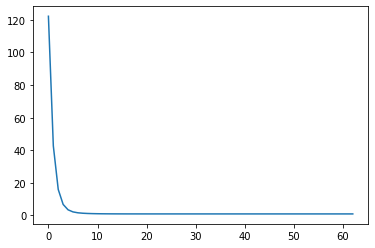

In [172]:
plt.plot(linreg_simple.loss_history)

# ** Задание 4 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [55]:
!ls

1.ipynb  train.csv


In [57]:
!head -n 2 train.csv

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455


In [60]:
data = pd.read_csv('train.csv', sep=',')

In [61]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [80]:
[col for col in data.columns if re.search( pattern,col) is None]

['pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration']

In [63]:
y = data['trip_duration']

In [81]:
pattern = re.compile(r'(id)|(_id)')

x = data[[col for col in data.columns if re.search( pattern,col) is None]]

In [182]:
x.head(3)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag_num
0,1,-73.982155,40.767937,-73.964630,40.765602,0
1,1,-73.980415,40.738564,-73.999481,40.731152,0
2,1,-73.979027,40.763939,-74.005333,40.710087,0


In [84]:
del x['trip_duration']

In [85]:
x.head(3)

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N


In [101]:
x.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype=object)

In [102]:
x['store_and_fwd_flag_num'] = x.store_and_fwd_flag.apply(lambda x: 0 if 'N' else 1)

In [104]:
del x['store_and_fwd_flag']

In [105]:
del x['pickup_datetime']

del x['dropoff_datetime']

In [87]:
y = np.log(y + 1)

In [93]:
x.shape

(1458644, 8)

In [94]:
y.shape

(1458644,)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8,  random_state=0)

# ** Задание 5 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [412]:
def plot_loss(loss, title, to_plot=None):
    if to_plot is None:
        plt.plot(range(len(loss['loss'])), loss['loss'],
                 label=f'{title}; alpha: {loss["alpha"]}; eta: {loss["eta"]}, rmse: {loss["rmse"]}')
    else:
        title = f'{title} '
        for pl in to_plot.split(' '):
            title += f'{pl}: {loss[pl]}'
        plt.plot(range(len(loss['loss'])), loss['loss'],
                 label=title)

In [415]:
def train_and_get_res(X_train, y_train, X_test, y_test, gd_type, alpha=1e-3,
                      eta=1e-6,  mod = None, max_iter=1000, batch_size=1):
    linreg = LinearReg(mod=mod, alpha=alpha, eta=eta, batch_size=batch_size, max_iter=max_iter)
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    rmse = rmse_score(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    print(f'Alpha {alpha};\nEta {eta}')
    print(f'RMSE {rmse}')    
    print(f'R2 {r2_score(y_pred, y_test)}')
    return {'loss' : linreg.loss_history, 'alpha' : alpha, 'eta' : eta, 
            'rmse' : rmse, r2 : r2,'batch_size' : batch_size, 'max_iter': max_iter }

In [174]:
def mse_score(y_true, y_pred):
    return np.power(np.sum(y_pred - y_true), 2) / y_true.shape[0]

In [175]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.power(np.sum(y_pred - y_true), 2) / y_true.shape[0])

In [176]:
def r2_score(y_true, y_pred):
    ss_tot = np.power(np.sum(y_true - np.mean(y_true)),2)
    ss_res = np.power(np.sum(y_pred - y_true), 2)
    return 1 - (ss_res/ss_tot)

### FGD

In [397]:
loss_full_eta = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',
                                       eta=1e-6)
loss_full_eta_9 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',
                                       eta=1e-9)
loss_full_eta_10 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',
                                       eta=1e-10)
loss_full_eta_7 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',
                                       eta=1e-7)
loss_full_eta_8 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',
                                       eta=1e-8)

Alpha 0.001;
Eta 1e-06
RMSE 32.024829843924785
R2 -7.029625492485125e+25




Alpha 0.001;
Eta 1e-09
RMSE 188323.67677037124
R2 -4.341572880734515e+31



Alpha 0.001;
Eta 1e-10
RMSE 142768.47874808343
R2 -1.8601294415773685e+31



Alpha 0.001;
Eta 1e-07
RMSE 11653.966209095059
R2 -1.768811311986831e+31



Alpha 0.001;
Eta 1e-08
RMSE 94034.44157106262
R2 -5.275461115030199e+32


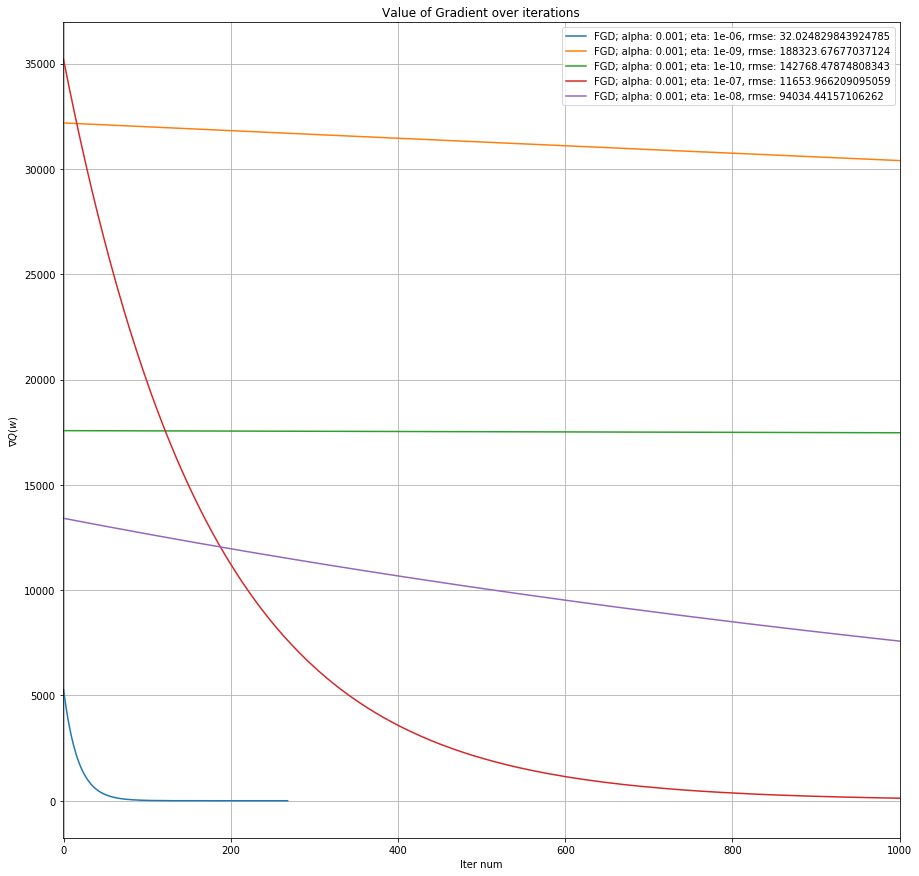

In [400]:
plt.figure(figsize=(15, 15))
plot_loss(loss_full_eta, 'FGD')
plot_loss(loss_full_eta_9, 'FGD')
plot_loss(loss_full_eta_10, 'FGD')
plot_loss(loss_full_eta_7, 'FGD')
plot_loss(loss_full_eta_8, 'FGD')

plt.title('Value of Gradient over iterations')
plt.xlim((-1, 1000))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'$\nabla Q$($w$)')
plt.grid()
plt.show()

In [399]:
loss_full_iter500 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',max_iter = 500,
                                       eta=1e-6)
loss_full_iter1500 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',max_iter = 1500,
                                       eta=1e-6)
loss_full_iter2000 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',max_iter = 2000,
                                       eta=1e-6)
loss_full_iter2500 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',max_iter = 2500,
                                       eta=1e-6)
loss_full_iter100 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='full',max_iter = 100,
                                       eta=1e-6)


Alpha 0.001;
Eta 1e-06
RMSE 2.8463043700246393
R2 -1.5307225712554404e+24



Alpha 0.001;
Eta 1e-06
RMSE 6.823251110465257
R2 -1.640105777268099e+26



Alpha 0.001;
Eta 1e-06
RMSE 89.1677048982237
R2 -1.7657729843251318e+27


Alpha 0.001;
Eta 1e-06
RMSE 29.514031278575054
R2 -1.5840744944404127e+27



Alpha 0.001;
Eta 1e-06
RMSE 6487.5657365073375
R2 -8.674497136103346e+32


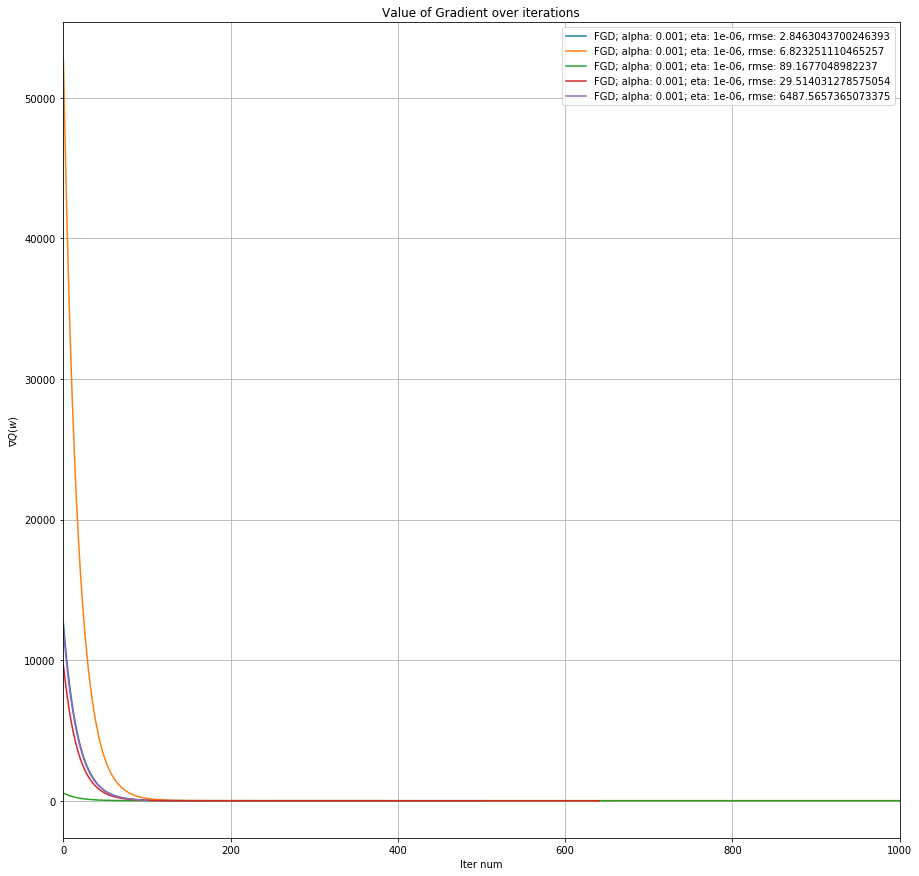

In [401]:
plt.figure(figsize=(15, 15))
plot_loss(loss_full_iter500, 'FGD')
plot_loss(loss_full_iter1500, 'FGD')
plot_loss(loss_full_iter2000, 'FGD')
plot_loss(loss_full_iter2500, 'FGD')
plot_loss(loss_full_iter100, 'FGD')

plt.title('Value of Gradient over iterations')
plt.xlim((-1, 1000))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'$\nabla Q$($w$)')
plt.grid()
plt.show()      

Маленькие значения величины шага в данном случае замедляют сходимость, однако, при большом значении величины шага алгоритм расходится.

### SGD

За итерацию обрабатывается 1 объект:

In [418]:
loss_full_b500 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastis',batch_size = 500,
                                       eta=1e-6)
loss_full_b100 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastis',batch_size = 100,
                                       eta=1e-6)
loss_full_b1000 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastis',batch_size = 1000,
                                       eta=1e-6)
loss_full_b50 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastis',batch_size = 50,
                                       eta=1e-6)
loss_full_b25 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastis',batch_size = 25,
                                       eta=1e-6)

Alpha 0.001;
Eta 1e-06
RMSE 65.44329263931274
R2 -9.326143993593363e+27


Alpha 0.001;
Eta 1e-06
RMSE 19.556434895082223
R2 -7.056575482919834e+25



Alpha 0.001;
Eta 1e-06
RMSE 15.395332475048015
R2 -1.0553776346984586e+26



Alpha 0.001;
Eta 1e-06
RMSE 0.16998537055309873
R2 -4.083677097986219e+21


Alpha 0.001;
Eta 1e-06
RMSE 213.33648019329223
R2 -2.2071502936424737e+29


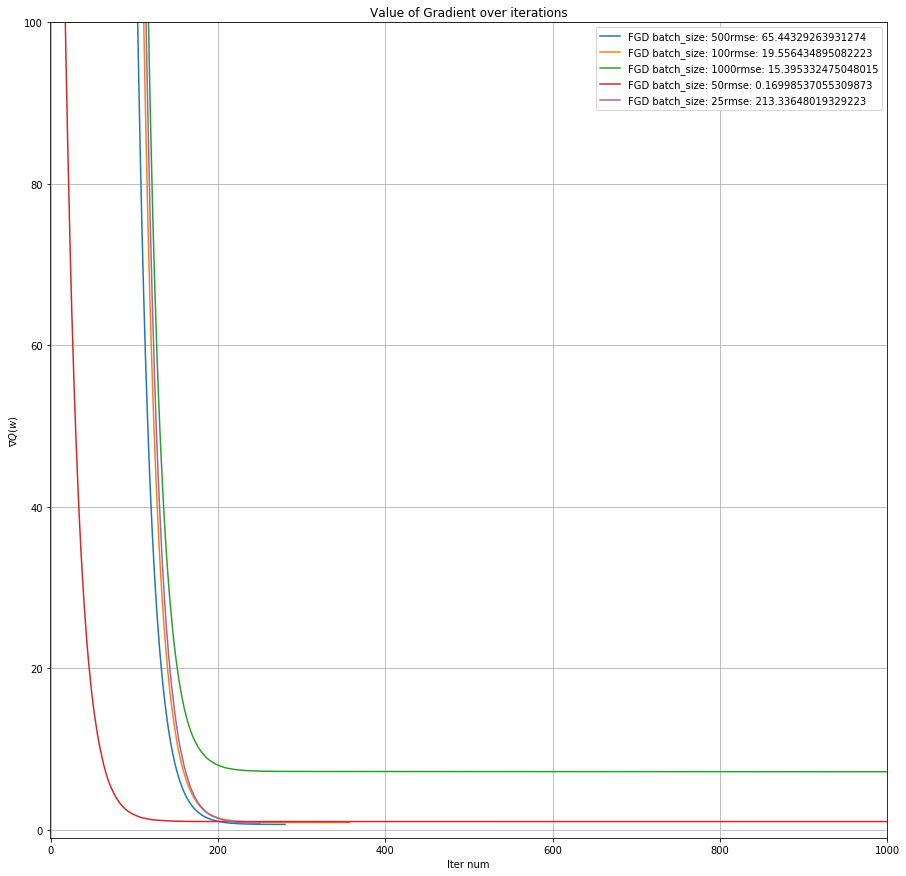

In [422]:
plt.figure(figsize=(15, 15))
plot_loss(loss_full_b500, 'FGD', to_plot='batch_size rmse')
plot_loss(loss_full_b100, 'FGD', to_plot='batch_size rmse')
plot_loss(loss_full_b1000, 'FGD', to_plot='batch_size rmse')
plot_loss(loss_full_b50, 'FGD', to_plot='batch_size rmse')
plot_loss(loss_full_b25, 'FGD', to_plot='batch_size rmse')

plt.title('Value of Gradient over iterations')
plt.xlim((-1, 1000))
plt.ylim((-1, 100))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'$\nabla Q$($w$)')
plt.grid()
plt.show()

### SGD MOMENTUM

In [ ]:
alpha=1e-3, eta=1e-6

In [373]:
loss_simple = train_and_get_res(X_train, y_train, X_test, y_test, gd_type='stochastic', mod='momentum')

Alpha 0.001;
Eta 1e-06
RMSE 20.077989392275054
R2 -3.509488467144749e+25


In [374]:
loss_simple_al_2 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-2, eta=1e-6)

Alpha 0.01;
Eta 1e-06
RMSE 231.47115649821774
R2 -1.3757522040179244e+29


In [375]:
loss_simple_al_1 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-1, eta=1e-6)



Alpha 0.1;
Eta 1e-06
RMSE 117.18310333522776
R2 -4.130500941476249e+27


In [376]:
loss_simple_al_4 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-4, eta=1e-6)

Alpha 0.0001;
Eta 1e-06
RMSE 1.120575656360608
R2 -2.2100389608241413e+23


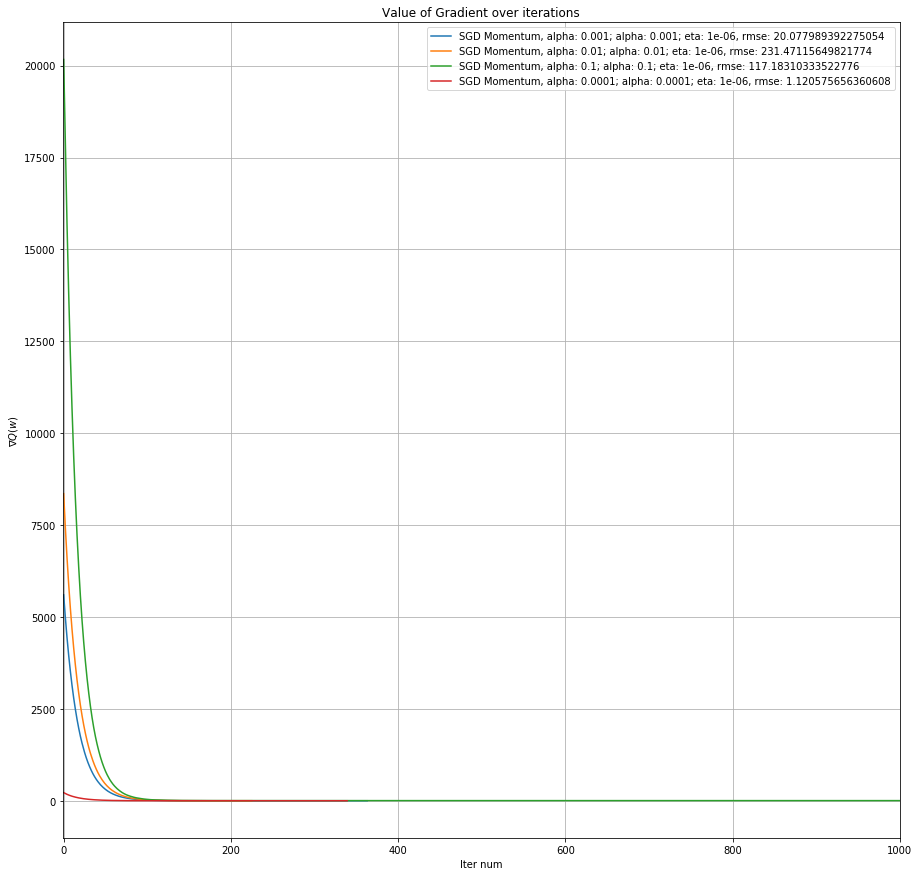

In [388]:
plt.figure(figsize=(15, 15))
plot_loss(loss_simple, 'SGD Momentum, alpha: 0.001')
plot_loss(loss_simple_al_2, 'SGD Momentum, alpha: 0.01')
plot_loss(loss_simple_al_1, 'SGD Momentum, alpha: 0.1')
plot_loss(loss_simple_al_4, 'SGD Momentum, alpha: 0.0001')

plt.title('Value of Gradient over iterations')
plt.xlim((-1, 1000))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'$\nabla Q$($w$)')
plt.grid()
plt.show()

In [390]:
loss_simple_eta = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-4, eta=1e-6)
loss_simple_eta_5 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-4, eta=1e-5)
loss_simple_eta_4 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-4, eta=1e-4)
loss_simple_eta_7 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-4, eta=1e-7)
loss_simple_eta_8 = train_and_get_res(X_train, y_train, X_test, 
                                      y_test, gd_type='stochastic', mod='momentum',
                                      alpha=1e-4, eta=1e-8)


Alpha 0.0001;
Eta 1e-06
RMSE 23.097045158976343
R2 -3.1211885918059375e+27


Alpha 0.0001;
Eta 1e-05
RMSE 48.200622909971514
R2 -6.109791927780693e+26



Alpha 0.0001;
Eta 0.0001
RMSE inf
R2 nan



Alpha 0.0001;
Eta 1e-07
RMSE 5593.172204565099
R2 -2.2944914956744728e+30



Alpha 0.0001;
Eta 1e-08
RMSE 9711.756744242932
R2 -5.1266099926788714e+29


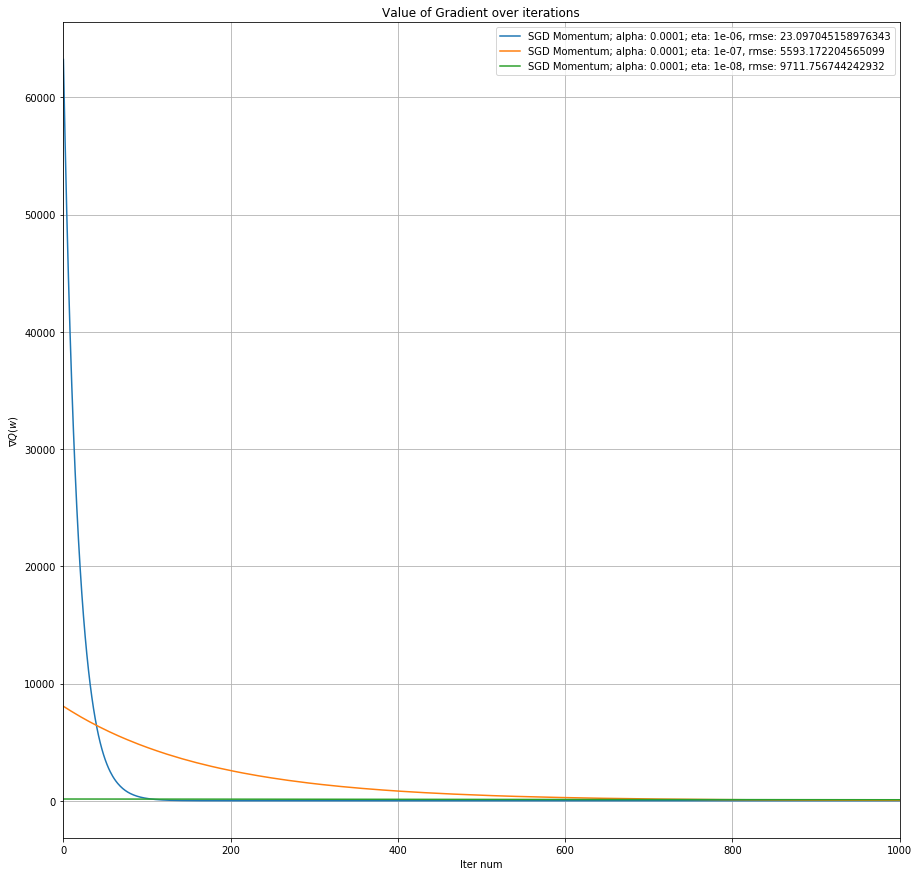

In [394]:
plt.figure(figsize=(15, 15))
plot_loss(loss_simple_eta, title='SGD Momentum')
#plot_loss(loss_simple_eta_5, title='SGD Momentum')
#plot_loss(loss_simple_eta_4, title='SGD Momentum')
plot_loss(loss_simple_eta_7, title='SGD Momentum')
plot_loss(loss_simple_eta_8, title='SGD Momentum')

plt.title('Value of Gradient over iterations')
plt.xlim((-1, 1000))
plt.legend()
plt.xlabel('Iter num')
plt.ylabel(r'$\nabla Q$($w$)')
plt.grid()
plt.show()

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

** Задание 6 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

In [ ]:
plt.figure(figsize=(15, 15))
plot_loss(loss_simple_eta, title='SGD Momentum')
plot_loss(loss_simple_eta_7, title='FGD')
plot_loss(loss_simple_eta_8, title='SGD')

### Бонус 

** Задание 7 (2 балла)**. Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью метода
[Adam](https://arxiv.org/pdf/1412.6980.pdf) - добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты. 

** Задание 8 (2 балла)**. Реализуйте линейную регрессию с функцией потерь
$$ L(\hat{y}, y) = log(cosh(\hat{y} - y)),$$

обучаемую с помощью градиентного спуска.

** Задание 9 (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook